In [7]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from pathlib import Path
FIGDIR = Path('../figures')
FIGDIR.mkdir(parents=True, exist_ok=True)
print('Figures will be saved to', FIGDIR.resolve())

# -----------------------
# Physical constants (cgs)
# -----------------------
G = 6.67430e-8               # cm^3 g^-1 s^-2
c = 2.99792458e10            # cm/s
M_sun_cgs = 1.98847e33       # g

# Geometric scaling units used in the handout
L0 = G * M_sun_cgs / c**2    # cm  (≈ 1.477 km)
T0 = G * M_sun_cgs / c**3    # s

# Unit conversions for presentation
cm_to_km = 1e-5
gcm3_to_kgm3 = 1000.0        # 1 g/cm^3 = 1000 kg/m^3

print(f"L0 = {L0:.6e} cm = {L0*cm_to_km:.6f} km")

# -----------------------
# EOS parameters (handout)
# -----------------------
Gamma = 1.3569
rho_r_ref = 1e13  # g/cm^3

# Handout: at rho_r=1e13 g/cm^3, it gives P/c^2 = 1.5689e31 dyn/cm^2 (weird units).
# Interpret the NUMBER as an energy-density scale, and convert dyn/cm^2 -> g/cm^3 by dividing by c^2 ONCE:
P_over_c2_ref_as_dyn_per_cm2 = 1.5689e31      # treat as (P/c^2) written in dyn/cm^2-equivalent
pbar_ref = P_over_c2_ref_as_dyn_per_cm2 / c**2  # -> g/cm^3

Kbar_cgs = pbar_ref / (rho_r_ref**Gamma)


print("Gamma =", Gamma)
print(f"pbar_ref = P_ref/c^2 = {pbar_ref:.6e} g/cm^3")
print(f"Kbar_cgs = {Kbar_cgs:.6e}  [(g/cm^3)^(1-Gamma)]")

# -----------------------
# Conversion: cgs mass-densities <-> geometric tilde
# In this convention we work with:
#   rho  := energy density / c^2  [g/cm^3]
#   pbar := pressure / c^2        [g/cm^3]
# In geometric units (G=c=1) these have the same dimensions and enter TOV as (rho + p).
# -----------------------
def x_cgs_to_tilde(x_cgs: float) -> float:
    # x_cgs in g/cm^3 -> x_tilde dimensionless (in L0 units)
    x_geom = x_cgs * G / c**2          # 1/cm^2
    return x_geom * L0**2

def x_tilde_to_cgs(x_tilde: float) -> float:
    # x_tilde -> g/cm^3
    x_geom = x_tilde / L0**2           # 1/cm^2
    return x_geom * c**2 / G

# EOS in cgs (mass-density convention)
def eos_cgs_from_rhor(rho_r_cgs: float):
    # returns (pbar, rho_total) in g/cm^3
    pbar = Kbar_cgs * rho_r_cgs**Gamma
    rho_tot = rho_r_cgs + pbar/(Gamma - 1)
    return pbar, rho_tot

def rhor_cgs_from_pbar(pbar_cgs: float) -> float:
    if pbar_cgs <= 0:
        return 0.0
    return (pbar_cgs / Kbar_cgs)**(1.0/Gamma)

def eos_tilde_from_pbar(pbar_tilde: float):
    # returns (rho_tot_tilde, rho_r_tilde)
    pbar_cgs = x_tilde_to_cgs(pbar_tilde)
    rho_r_cgs = rhor_cgs_from_pbar(pbar_cgs)
    _, rho_tot_cgs = eos_cgs_from_rhor(rho_r_cgs)
    return x_cgs_to_tilde(rho_tot_cgs), x_cgs_to_tilde(rho_r_cgs)


Figures will be saved to /Users/cafer/Desktop/PHYS 414/final_project/figures
L0 = 1.476670e+05 cm = 1.476670 km
Gamma = 1.3569
pbar_ref = P_ref/c^2 = 1.745637e+10 g/cm^3
Kbar_cgs = 4.001786e-08  [(g/cm^3)^(1-Gamma)]


In [8]:

def tov_rhs(r, y):
    m, pbar, nu, mP = y
    if r <= 0:
        return [0, 0, 0, 0]
    rho, rho_r = eos_tilde_from_pbar(pbar)

    denom = r * (r - 2*m)
    if denom <= 0:
        return [0, 0, 0, 0]

    dm  = 4*np.pi * r**2 * rho
    dnu = 2*(m + 4*np.pi*r**3 * pbar) / denom
    dp  = -(rho + pbar) * (m + 4*np.pi*r**3 * pbar) / denom
    dmP = 4*np.pi * r**2 * rho_r / np.sqrt(1 - 2*m/r)
    return [dm, dp, dnu, dmP]

def event_surface(r, y):
    return y[1]   # pbar -> 0 at surface
event_surface.terminal = True
event_surface.direction = -1

def event_horizon_like(r, y):
    return r - 2*y[0]
event_horizon_like.terminal = True
event_horizon_like.direction = -1

def integrate_star(rho_r_c_cgs: float, r_max_tilde=80.0):
    # central values in cgs (g/cm^3 for rho, pbar)
    pbar_c_cgs, rho_c_cgs = eos_cgs_from_rhor(rho_r_c_cgs)

    # convert to tilde
    pbar_c = x_cgs_to_tilde(pbar_c_cgs)
    rho_c  = x_cgs_to_tilde(rho_c_cgs)
    rho_r_c= x_cgs_to_tilde(rho_r_c_cgs)

    r0 = 1e-6
    m0  = (4*np.pi/3) * rho_c  * r0**3
    mP0 = (4*np.pi/3) * rho_r_c* r0**3
    nu0 = 0.0

    sol = solve_ivp(
        tov_rhs,
        t_span=(r0, r_max_tilde),
        y0=[m0, pbar_c, nu0, mP0],
        events=[event_surface, event_horizon_like],
        rtol=1e-6,
        atol=1e-9,
        max_step=0.2
    )

    r_surf = sol.t_events[0][0] if len(sol.t_events[0])>0 else sol.t[-1]
    m_surf, p_surf, nu_surf, mP_surf = sol.y[:, -1]

    M = m_surf
    R_km = r_surf * L0 * cm_to_km
    MP = mP_surf
    Delta = (MP - M)/M if M>0 else np.nan

    rho_c_kgm3 = rho_c_cgs * gcm3_to_kgm3

    # nu shift so that nu(infty)=0
    R_tilde = r_surf
    if R_tilde > 2*M:
        nu_inf = -np.log(1 - 2*M/R_tilde) + nu_surf
    else:
        nu_inf = np.nan

    return {
        "rho_r_c_cgs": rho_r_c_cgs,
        "rho_c_cgs": rho_c_cgs,
        "rho_c_kgm3": rho_c_kgm3,
        "pbar_c_cgs": pbar_c_cgs,
        "M": M,
        "R_km": R_km,
        "R_tilde": R_tilde,
        "MP": MP,
        "Delta": Delta,
        "nu_surface_raw": nu_surf,
        "nu_inf_raw": nu_inf,
        "sol": sol
    }


In [9]:

# Sweep central densities
rho_r_grid = np.logspace(13.0, 16.2, 70)  # g/cm^3

results=[]
for rho_r_c in rho_r_grid:
    try:
        results.append(integrate_star(rho_r_c))
    except Exception as e:
        print("failed at", rho_r_c, e)

M_arr = np.array([d["M"] for d in results])
R_arr = np.array([d["R_km"] for d in results])
MP_arr = np.array([d["MP"] for d in results])
Delta_arr = np.array([d["Delta"] for d in results])
rho_c_arr = np.array([d["rho_c_kgm3"] for d in results])

i_max = np.nanargmax(M_arr)
print("Max M ~ %.3f Msun at R ~ %.2f km, rho_c ~ %.3e kg/m^3" % (M_arr[i_max], R_arr[i_max], rho_c_arr[i_max]))


Max M ~ 0.084 Msun at R ~ 12.01 km, rho_c ~ 1.012e+18 kg/m^3


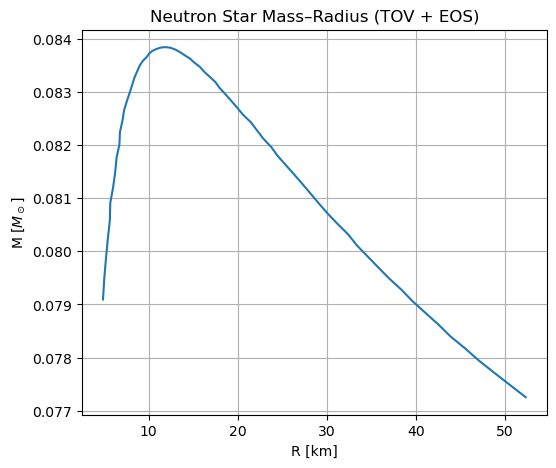

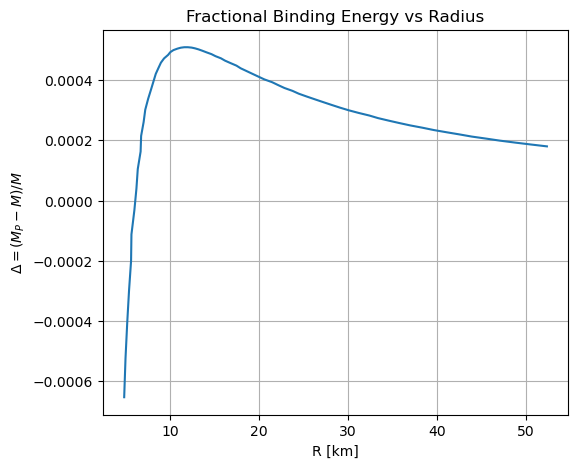

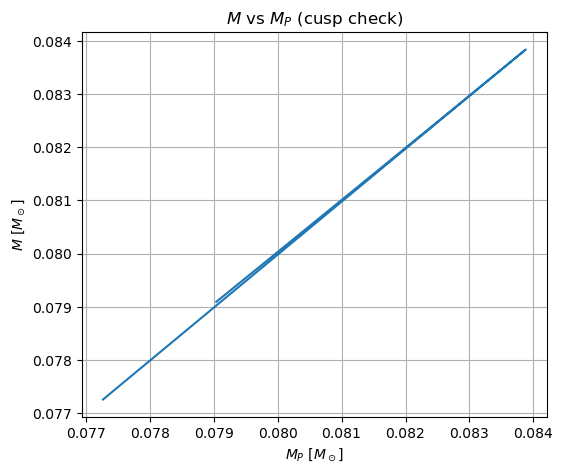

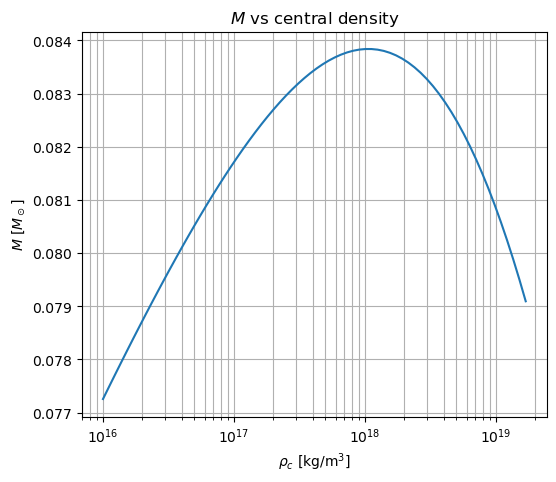

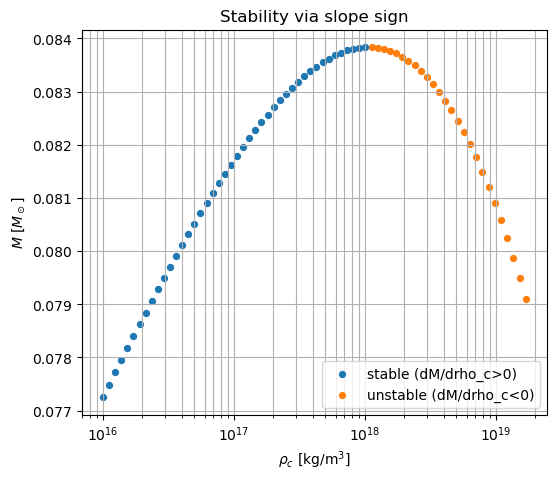

In [10]:

# -----------------------
# Required plots
# -----------------------

# (a) M-R curve
plt.figure(figsize=(6,5))
plt.plot(R_arr, M_arr)
plt.xlabel("R [km]")
plt.ylabel(r"M [$M_\odot$]")
plt.title("Neutron Star Mass–Radius (TOV + EOS)")
plt.grid(True)
plt.savefig(FIGDIR/'tov_plot_1.png', dpi=200, bbox_inches='tight')
plt.show()

# (b) Binding energy fraction Delta vs R
plt.figure(figsize=(6,5))
plt.plot(R_arr, Delta_arr)
plt.xlabel("R [km]")
plt.ylabel(r"$\Delta = (M_P - M)/M$")
plt.title("Fractional Binding Energy vs Radius")
plt.grid(True)
plt.savefig(FIGDIR/'tov_plot_2.png', dpi=200, bbox_inches='tight')
plt.show()

# (b) M vs MP (cusps check)
plt.figure(figsize=(6,5))
plt.plot(MP_arr, M_arr)
plt.xlabel(r"$M_P\ [M_\odot]$")
plt.ylabel(r"$M\ [M_\odot]$")
plt.title(r"$M$ vs $M_P$ (cusp check)")
plt.grid(True)
plt.savefig(FIGDIR/'tov_plot_3.png', dpi=200, bbox_inches='tight')
plt.show()

# (c) M vs rho_c and stability sign via dM/drho_c
# numerical derivative in log space is noisy; do a simple gradient
dM_drho = np.gradient(M_arr, np.log10(rho_c_arr))  # sign is more robust in log-space

plt.figure(figsize=(6,5))
plt.plot(rho_c_arr, M_arr)
plt.xscale("log")
plt.xlabel(r"$\rho_c\ [\mathrm{kg/m^3}]$")
plt.ylabel(r"$M\ [M_\odot]$")
plt.title(r"$M$ vs central density")
plt.grid(True, which="both")
plt.savefig(FIGDIR/'tov_plot_4.png', dpi=200, bbox_inches='tight')
plt.show()

# Mark stable vs unstable roughly
stable_mask = dM_drho > 0
plt.figure(figsize=(6,5))
plt.scatter(rho_c_arr[stable_mask], M_arr[stable_mask], s=18, label="stable (dM/drho_c>0)")
plt.scatter(rho_c_arr[~stable_mask], M_arr[~stable_mask], s=18, label="unstable (dM/drho_c<0)")
plt.xscale("log")
plt.xlabel(r"$\rho_c\ [\mathrm{kg/m^3}]$")
plt.ylabel(r"$M\ [M_\odot]$")
plt.title("Stability via slope sign")
plt.legend()
plt.grid(True, which="both")
plt.savefig(FIGDIR/'tov_plot_5.png', dpi=200, bbox_inches='tight')
plt.show()


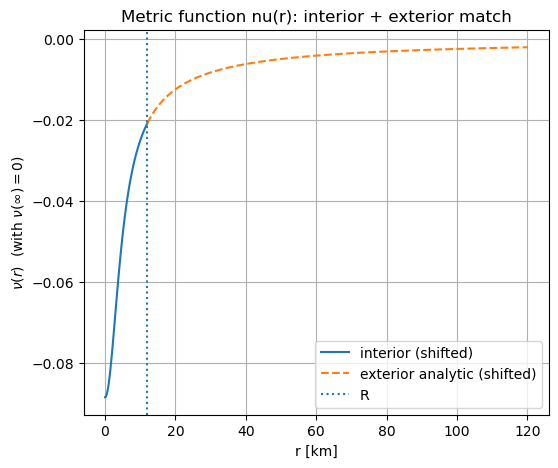

e^{nu(0)/2} (time dilation at center vs infinity) = 0.9567805206104648


In [11]:

# (e) Exterior solution for nu(r) (opbartional check)
# Pick a repbarresentative star (near maximum mass)
star = results[i_max]
sol = star["sol"]

r = sol.t
m = sol.y[0]
pbar = sol.y[1]
nu_raw = sol.y[2]

R_tilde = star["R_tilde"]
M = star["M"]
nuR = nu_raw[-1]

# shift nu so that nu(infty)=0 using the handout formula
nu_inf = -np.log(1 - 2*M/R_tilde) + nuR
nu = nu_raw - nu_inf

# Build exterior nu(r) on a grid beyond R
r_ext = np.linspace(R_tilde, 10*R_tilde, 200)
nu_ext = np.log(1 - 2*M/r_ext) - np.log(1 - 2*M/R_tilde) + nuR - nu_inf

plt.figure(figsize=(6,5))
plt.plot(r*L0*cm_to_km, nu, label="interior (shifted)")
plt.plot(r_ext*L0*cm_to_km, nu_ext, "--", label="exterior analytic (shifted)")
plt.axvline(star["R_km"], ls=":", label="R")
plt.xlabel("r [km]")
plt.ylabel(r"$\nu(r)$  (with $\nu(\infty)=0$)")
plt.title("Metric function nu(r): interior + exterior match")
plt.legend()
plt.grid(True)
plt.show()

# Central time dilation factor (relative to infinity)
time_dilation_center = np.exp(nu[0]/2)
print("e^{nu(0)/2} (time dilation at center vs infinity) =", time_dilation_center)


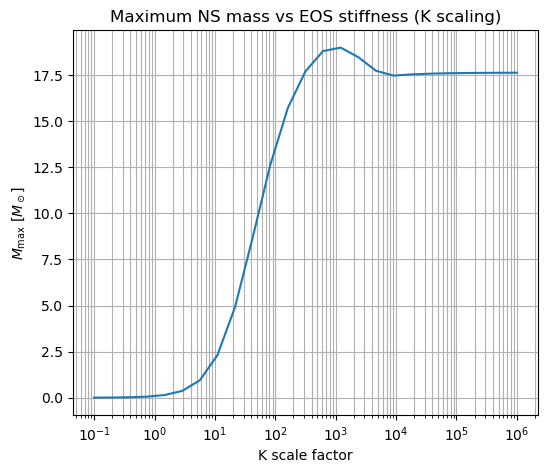

Approx. minimum K_scale to reach M_max >= 2.5 Msun: 11.6


In [12]:

# Vary Kbar and see how maximum mass changes
def build_curve_for_Kbar(K_scale: float, rho_r_grid=np.logspace(13.0, 16.2, 50)):
    global Kbar_cgs
    K_saved = Kbar_cgs
    Kbar_cgs = K_saved * K_scale

    M_list=[]
    for rho_r_c in rho_r_grid:
        try:
            out = integrate_star(rho_r_c)
            M_list.append(out["M"])
        except Exception:
            M_list.append(np.nan)

    Kbar_cgs = K_saved
    return np.array(M_list)

K_scales = np.logspace(-1, 6, 25)  
Mmax = np.array([np.nanmax(build_curve_for_Kbar(s)) for s in K_scales])

plt.figure(figsize=(6,5))
plt.plot(K_scales, Mmax)
plt.xscale("log")
plt.xlabel("K scale factor")
plt.ylabel(r"$M_{\max}\ [M_\odot]$")
plt.title("Maximum NS mass vs EOS stiffness (K scaling)")
plt.grid(True, which="both")
plt.savefig(FIGDIR/'ns_Mmax_vs_Kscale.png', dpi=200, bbox_inches='tight')
plt.show()

target = 2.5
ok = Mmax >= target
if np.any(ok):
    idx = np.argmax(ok)
    if idx == 0:
        s_req = K_scales[0]
    else:
        x0, x1 = np.log(K_scales[idx-1]), np.log(K_scales[idx])
        y0, y1 = Mmax[idx-1], Mmax[idx]
        s_req = np.exp(x0 + (target - y0)*(x1 - x0)/(y1 - y0))
    print(f"Approx. minimum K_scale to reach M_max >= {target} Msun: {s_req:.3g}")
else:
    print("Even K_scale=10 did not reach 2.5 Msun in this scan. Increase K_scales range.")
